In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [26]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [27]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

ModuleNotFoundError: No module named 'google'

In [28]:
path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

In [29]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [30]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

# Apply the mapping to create numerical labels
y = df['Interaction'].replace(contact_dict)
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_16555/1592439739.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


In [31]:
# Encode categorical features
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

In [32]:
# Count total missing values per column
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


In [33]:
# Fill None values with the mean of the values of that column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

Total missing values, after refilling: 0

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
0 -2.322  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0   
1 -1.788  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0   
2 -2.390  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0   
3 -1.088 -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0   
4 -1.551 -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0   

   s_ss8_encoded  t_ss8_encoded  
0              3              7  


## Feature engineering


*   Sum
*   Product
*   Absolute difference
*   Average



In [34]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names


In [35]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
# UPDATE WITH NEW ENGINEERED FEATURES
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

for feature in features:
  feature_names.extend(fe(feature))

Engineering feature: ss8_encoded
   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   ...   t_a3   t_a4   t_a5  t_3di_state  s_ss8_encoded  t_ss8_encoded  \
0  ...  0.533 -0.277  1.648          6.0              3              7   
1  ... -0.862 -1.020 -0.255          4.0              0              1   
2  ... -3.005 -0.503 -1.853          2.0              2              0   
3  ... -4.760  0.670 -2.647         17.0              4              4   
4  ...  1.477  0.113 -0.837         13.0              0              3   

   ss8_encoded_sum  ss8_encoded_abs

In [10]:
print(feature_names)

['s_ss8', 's_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 'ss8_encoded_sum', 'ss8_encoded_abs_diff', 'ss8_encoded_prod', 'ss8_encoded_avg', 'rsa_sum', 'rsa_abs_diff', 'rsa_prod', 'rsa_avg', 'phi_sum', 'phi_abs_diff', 'phi_prod', 'phi_avg', 'psi_sum', 'psi_abs_diff', 'psi_prod', 'psi_avg', 'a1_sum', 'a1_abs_diff', 'a1_prod', 'a1_avg', 'a2_sum', 'a2_abs_diff', 'a2_prod', 'a2_avg', 'a3_sum', 'a3_abs_diff', 'a3_prod', 'a3_avg', 'a4_sum', 'a4_abs_diff', 'a4_prod', 'a4_avg', 'a5_sum', 'a5_abs_diff', 'a5_prod', 'a5_avg', '3di_state_sum', '3di_state_abs_diff', '3di_state_prod', '3di_state_avg']


## Scaling features

In [36]:
# Scale all features to the range [0, 1]
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)
input_dim = X_scaled.shape[1]

In [37]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.2,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [38]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

0: 675794
1: 471719
2: 24501
3: 22650
4: 5686
5: 1344
6: 1146
7: 697310


In [39]:
sampling_strategy = {
    0: 675794,  # HBOND
    1: 471719,  # VDW
    2: 24501,  # PIPISTACK
    3: 22650,  # IONIC
    4: 20000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 697310   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train)):
    print(f"{label}: {Counter(y_train)[label]}")


Resampled y_train_bal distribution
0: 675794
1: 471719
2: 24501
3: 22650
4: 20000
5: 10000
6: 10000
7: 697310


## XGBoost

### Helper functions

In [40]:
def feature_importance(model, interaction_type, feature_names):
  # Estrai le importanze delle feature
  importance = model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'

  # Ordinare le feature per importanza
  # Create a mapping from old keys to new feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

  # Replace keys in the importance dictionary
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sort the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Visualizza l'importanza delle feature
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
  plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
  plt.show()

In [41]:
import time

def evaluate_model(model, X_test, y_test, class_num, feature_names, selected_feature_indices=None):
    """
    Evaluate performance of an XGBoost model.

    Parameters:
    -----------
    model_path: str
        Path to the model file
    X_test: numpy array
        Test features
    y_test: numpy array
        Test labels
    class_num: int
        Class number for binary evaluation
    """
    # Binary labels for test data
    y_test_binary = (y_test == class_num).astype(int)

    # Convert test data to DMatrix
    dtest = xgb.DMatrix(X_test)

    # Get predictions from the model
    start_time = time.time()
    y_pred_prob = model.predict(dtest)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'AUC-ROC',
            'Matthews Correlation',
            'Average Precision',
            'Inference Time (ms)',
        ],
        'Value': [
            accuracy_score(y_test_binary, y_pred_binary),
            balanced_accuracy_score(y_test_binary, y_pred_binary),
            roc_auc_score(y_test_binary, y_pred_prob),
            matthews_corrcoef(y_test_binary, y_pred_binary),
            average_precision_score(y_test_binary, y_pred_prob),
            inference_time * 1000,
        ]
    }

    # Create a DataFrame for metrics
    metrics_df = pd.DataFrame(metrics)

    print(f"\n===== Performance Metrics for Class {class_num} =====")
    print(metrics_df.set_index('Metric').round(4))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Other', f'Class {class_num}'],
                yticklabels=['Other', f'Class {class_num}'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Class {class_num}')
    plt.show()

    print(f"\n===== Feature Importance for Class {class_num} =====")

    # 8. Feature importance
    feature_importance(model, class_num, feature_names)

    return metrics_df, y_pred_prob

### Train loop

Training classifier for Class 0


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.63420
[100]	validation-auc:0.70945
[200]	validation-auc:0.71690
[300]	validation-auc:0.71946
[363]	validation-auc:0.71954

===== Performance Metrics for Class 0 =====
                          Value
Metric                         
Accuracy                 0.6439
Balanced Accuracy        0.6605
AUC-ROC                  0.7206
Matthews Correlation     0.3074
Average Precision        0.5565
Inference Time (ms)   1651.7019


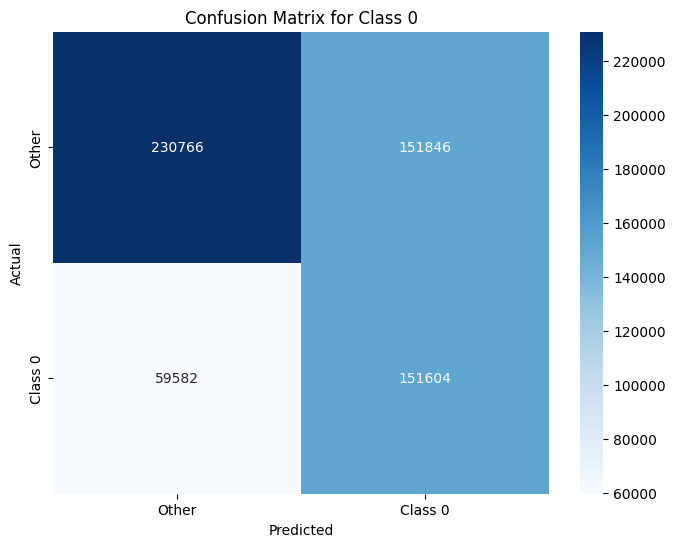


===== Feature Importance for Class 0 =====


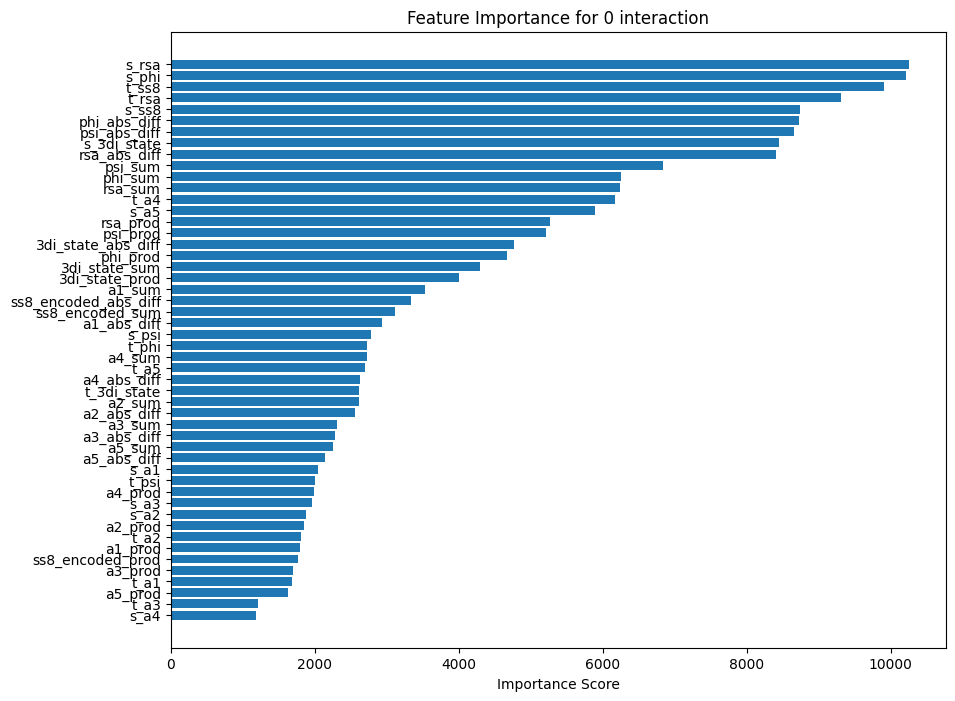

Training classifier for Class 1


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:39:06] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.53851
[72]	validation-auc:0.55415

===== Performance Metrics for Class 1 =====
                         Value
Metric                        
Accuracy                0.5162
Balanced Accuracy       0.5382
AUC-ROC                 0.5549
Matthews Correlation    0.0660
Average Precision       0.2833
Inference Time (ms)   321.0890


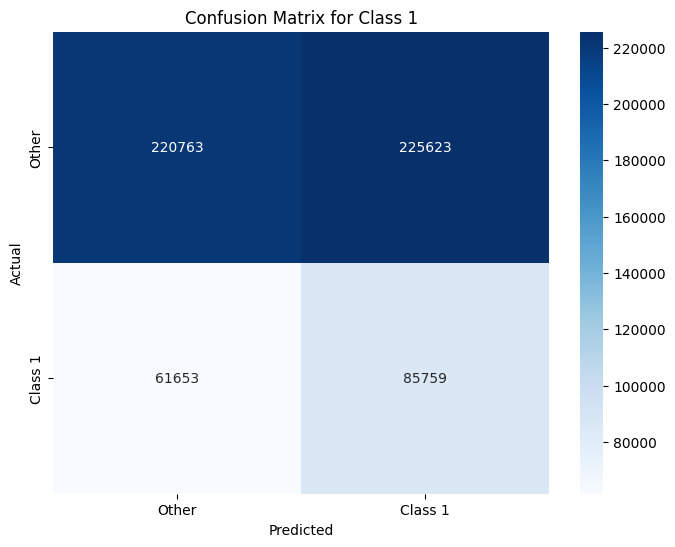


===== Feature Importance for Class 1 =====


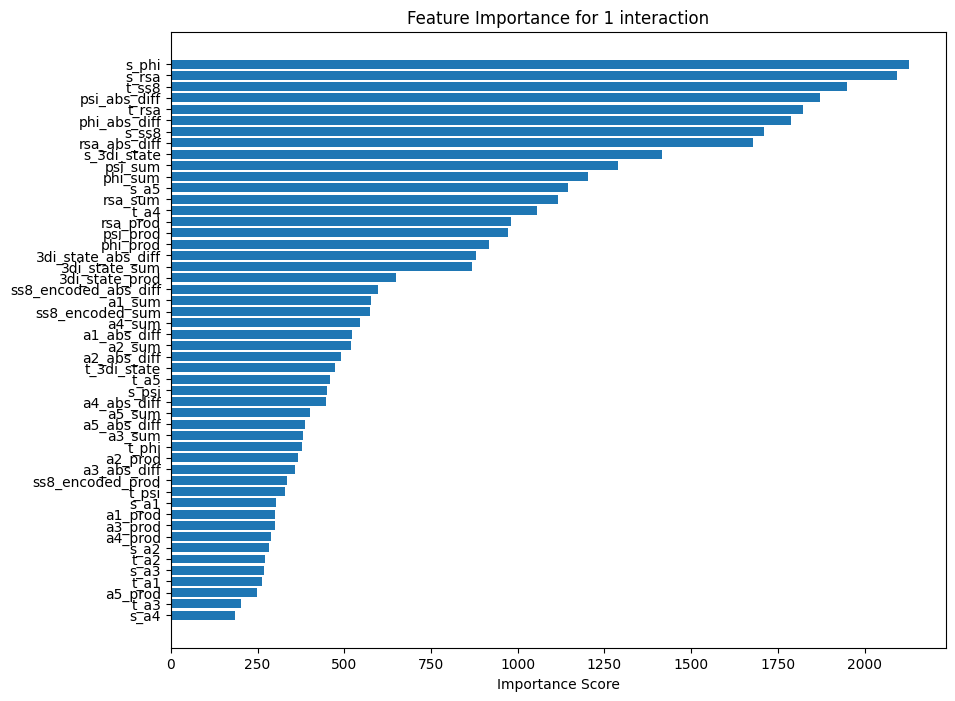

Training classifier for Class 2


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:39:22] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.99029
[96]	validation-auc:0.99107

===== Performance Metrics for Class 2 =====
                         Value
Metric                        
Accuracy                0.9790
Balanced Accuracy       0.9885
AUC-ROC                 0.9910
Matthews Correlation    0.6096
Average Precision       0.4463
Inference Time (ms)   137.4202


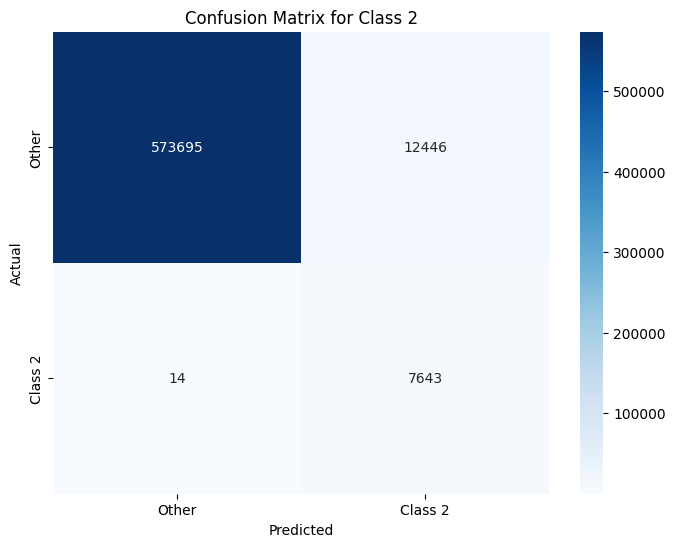


===== Feature Importance for Class 2 =====


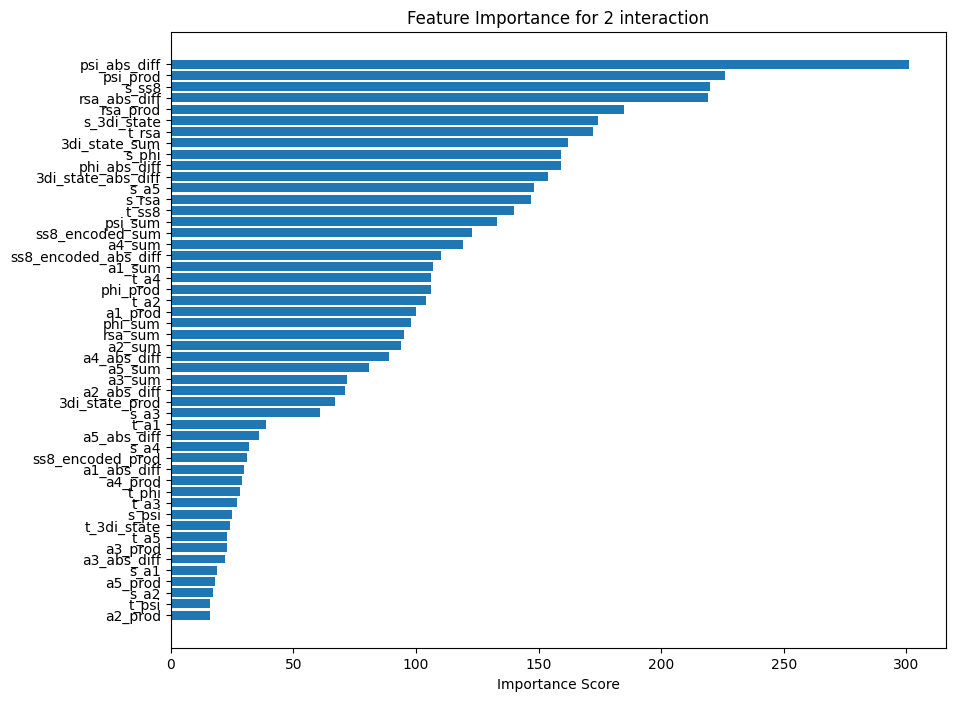

Training classifier for Class 3


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:39:33] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.97661
[81]	validation-auc:0.97808

===== Performance Metrics for Class 3 =====
                         Value
Metric                        
Accuracy                0.9415
Balanced Accuracy       0.9640
AUC-ROC                 0.9775
Matthews Correlation    0.3944
Average Precision       0.2393
Inference Time (ms)   128.9279


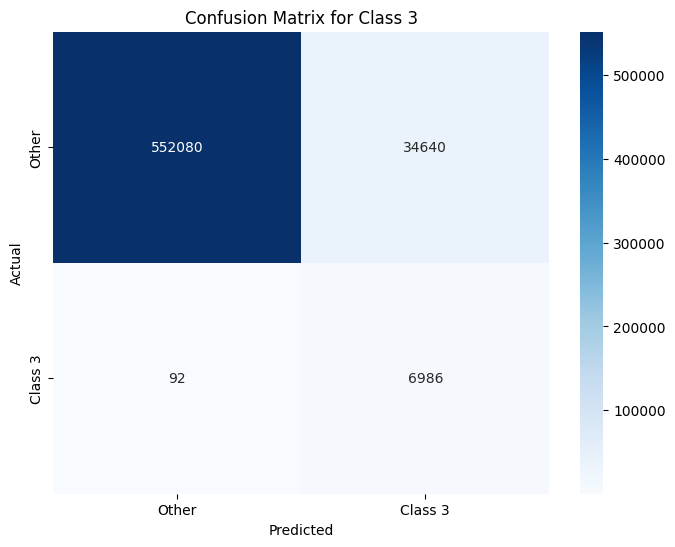


===== Feature Importance for Class 3 =====


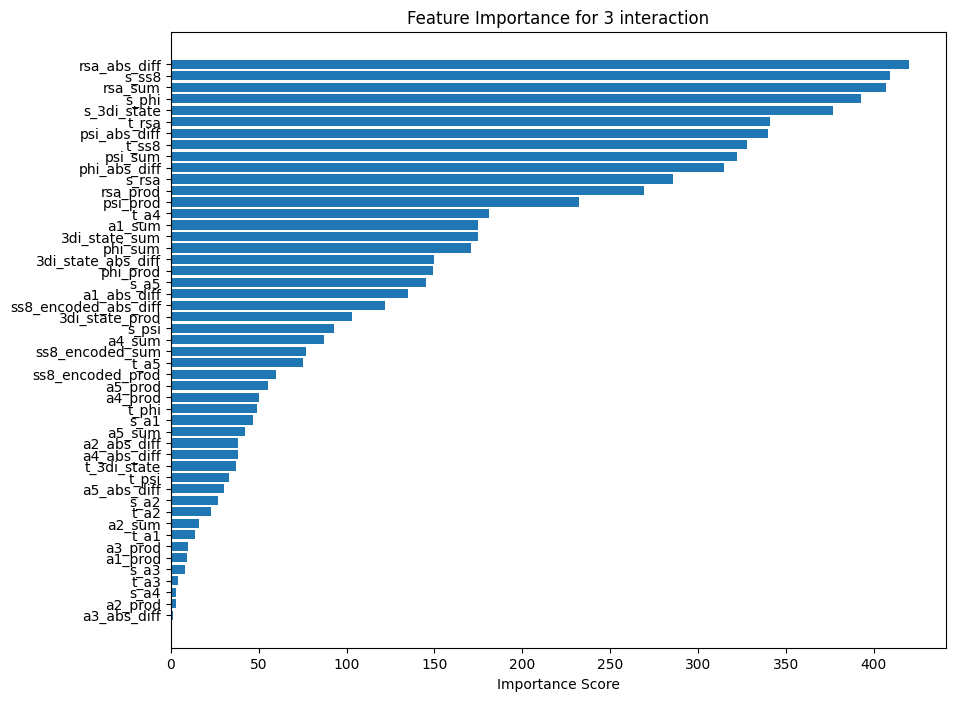

Training classifier for Class 4


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:39:43] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.98945
[66]	validation-auc:0.99101

===== Performance Metrics for Class 4 =====
                        Value
Metric                       
Accuracy               0.9764
Balanced Accuracy      0.9708
AUC-ROC                0.9914
Matthews Correlation   0.3210
Average Precision      0.1835
Inference Time (ms)   83.6170


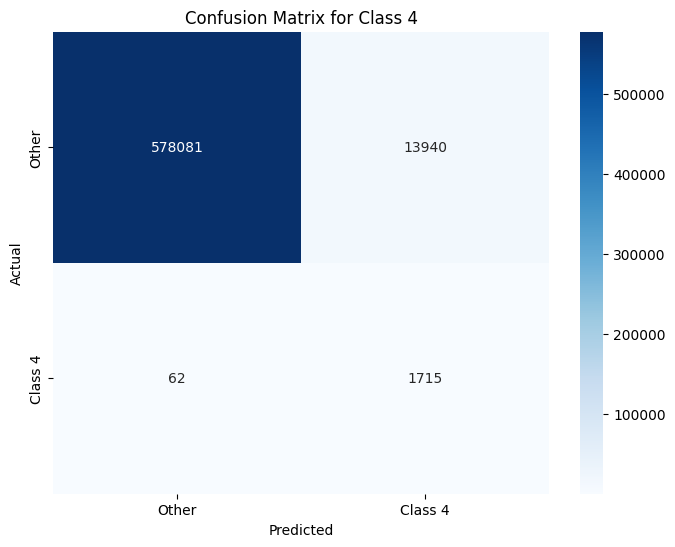


===== Feature Importance for Class 4 =====


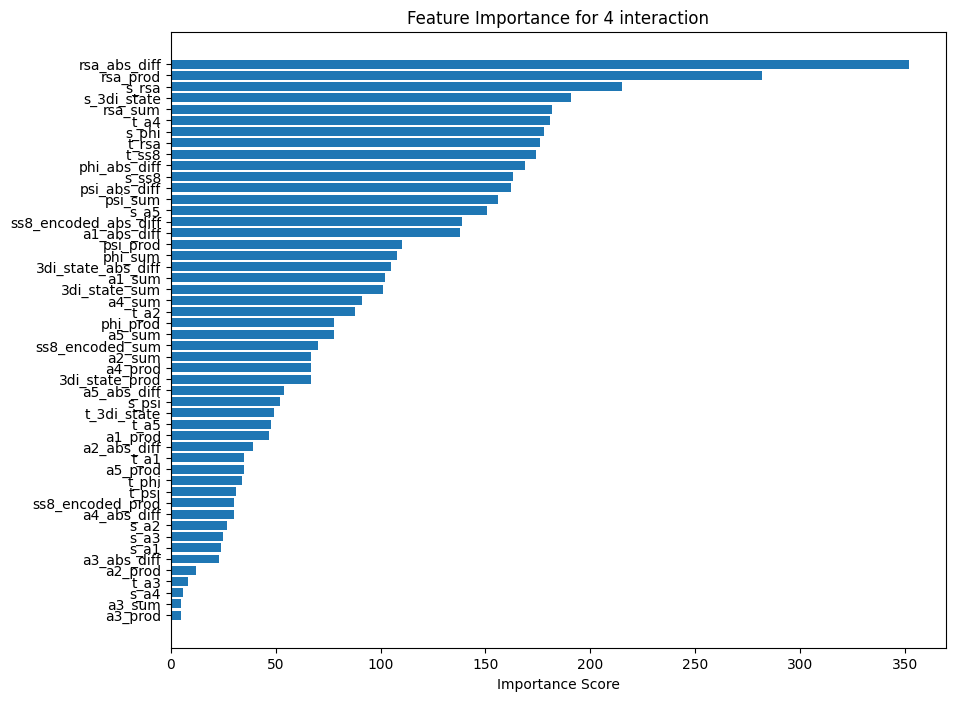

Training classifier for Class 5


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:39:52] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.99945
[52]	validation-auc:0.99954

===== Performance Metrics for Class 5 =====
                        Value
Metric                       
Accuracy               0.9990
Balanced Accuracy      0.9876
AUC-ROC                0.9995
Matthews Correlation   0.6374
Average Precision      0.4226
Inference Time (ms)   25.3351


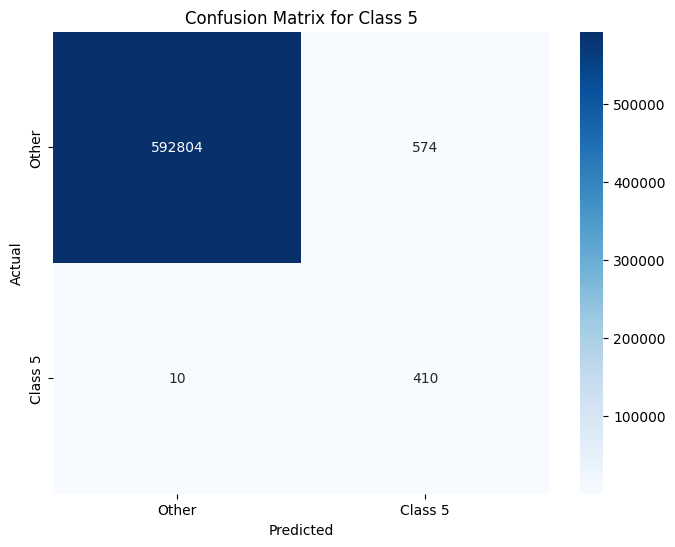


===== Feature Importance for Class 5 =====


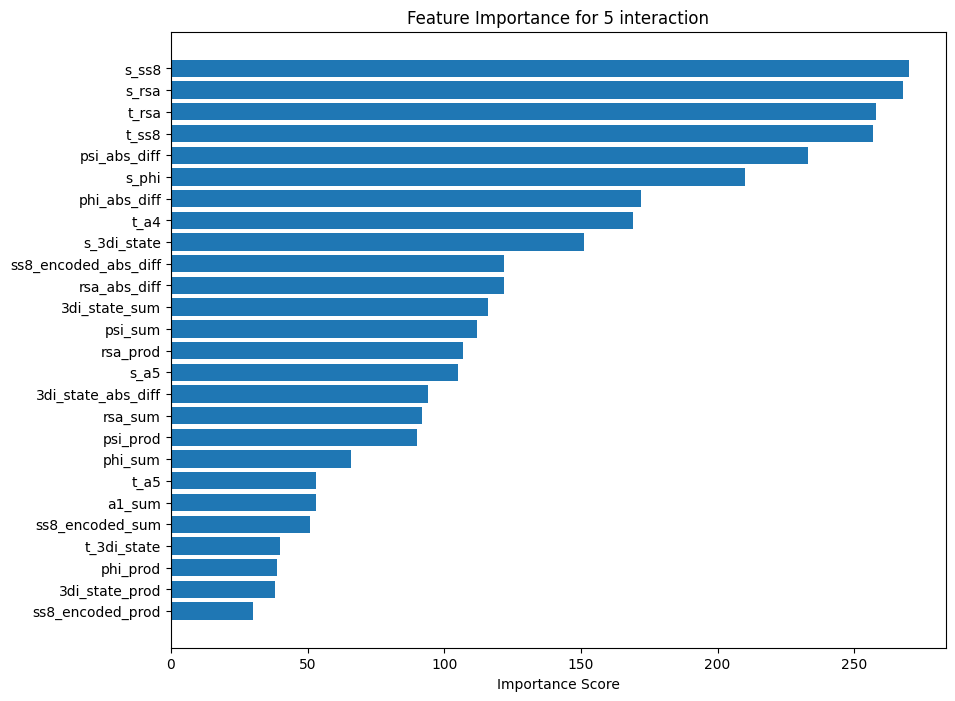

Training classifier for Class 6


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:39:59] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.94134
[20]	validation-auc:0.94670

===== Performance Metrics for Class 6 =====
                        Value
Metric                       
Accuracy               0.9373
Balanced Accuracy      0.9002
AUC-ROC                0.9525
Matthews Correlation   0.0808
Average Precision      0.0174
Inference Time (ms)   92.8581


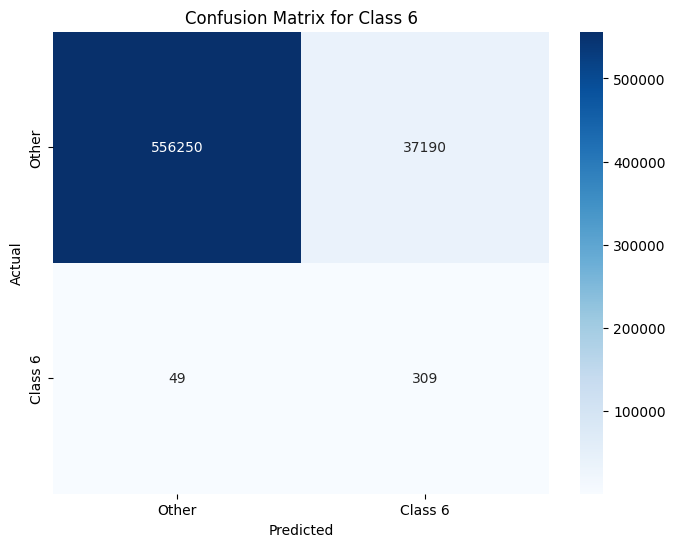


===== Feature Importance for Class 6 =====


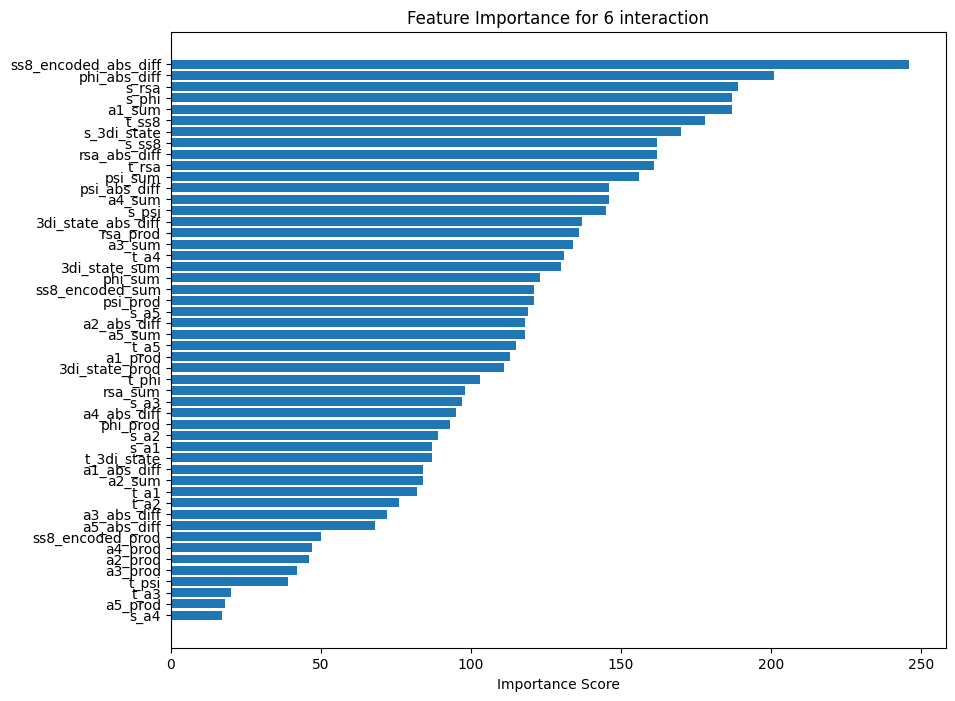

Training classifier for Class 7


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:40:06] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.65380
[100]	validation-auc:0.73473
[200]	validation-auc:0.74749
[300]	validation-auc:0.75539
[400]	validation-auc:0.76101
[500]	validation-auc:0.76541
[600]	validation-auc:0.76898
[700]	validation-auc:0.77203
[800]	validation-auc:0.77441
[900]	validation-auc:0.77660
[1000]	validation-auc:0.77859
[1100]	validation-auc:0.78045
[1200]	validation-auc:0.78221
[1300]	validation-auc:0.78377
[1400]	validation-auc:0.78543
[1500]	validation-auc:0.78688
[1600]	validation-auc:0.78794
[1700]	validation-auc:0.78915
[1800]	validation-auc:0.79030
[1900]	validation-auc:0.79132
[2000]	validation-auc:0.79230
[2100]	validation-auc:0.79323
[2200]	validation-auc:0.79404
[2300]	validation-auc:0.79492
[2400]	validation-auc:0.79570
[2499]	validation-auc:0.79628

===== Performance Metrics for Class 7 =====
                           Value
Metric                          
Accuracy                  0.7339
Balanced Accuracy         0.7183
AUC-ROC                   0.7953
Matthews Correlation  

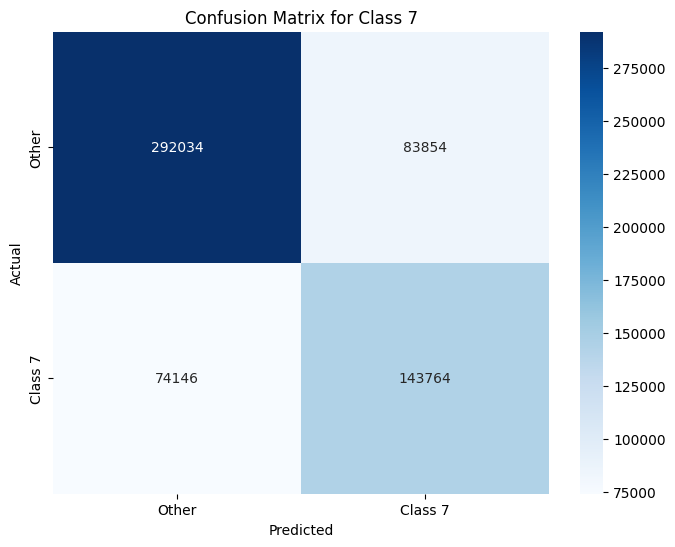


===== Feature Importance for Class 7 =====


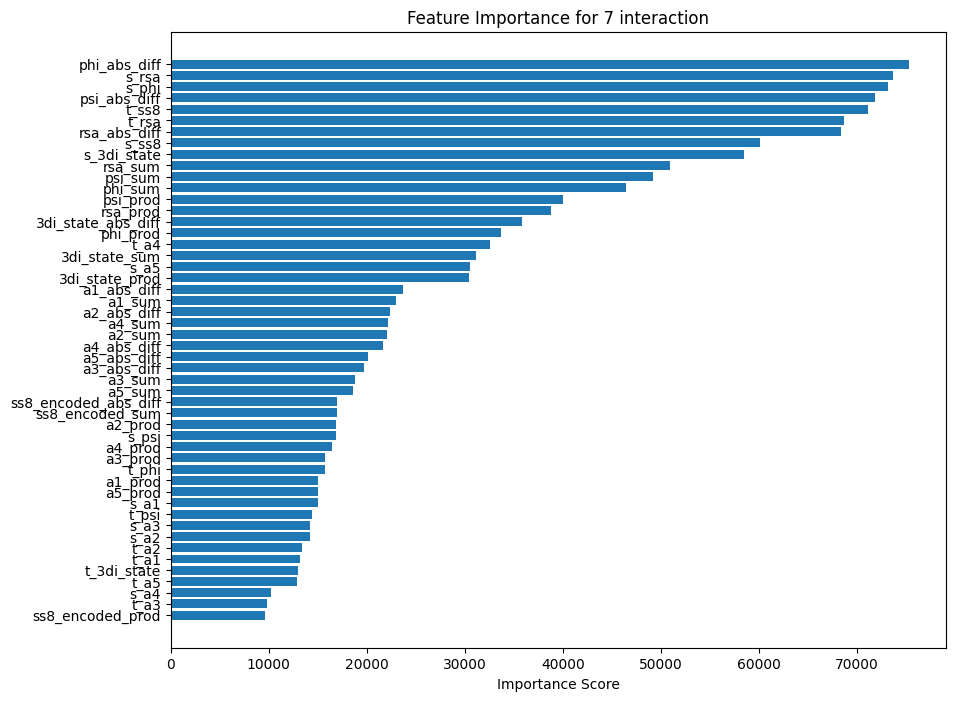

In [42]:
# Create arrays to store models and predictions
models = []
all_class_predictions = np.zeros((len(y_test), len(np.unique(y_train))))

# For each class, train a binary classifier
for num_class in range(len(np.unique(y_train))):
    print(f'Training classifier for Class {num_class}')

    # Create binary labels for ALL training examples
    # 1 for current class, 0 for all other classes
    y_train_binary = (y_train == num_class).astype(int)
    y_val_binary = (y_val == num_class).astype(int)


    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train_binary)
    dval = xgb.DMatrix(X_val, label=y_val_binary)

    # Counte num positive/negative examples for this class
    pos_class = np.sum(y_train_binary == 1)
    neg_class = np.sum(y_train_binary == 0)

    # Train model
    model = xgb.train(
        params = {
            'device': 'cuda',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 10,
            'learning_rate': 0.1,
            'scale_pos_weight': neg_class / pos_class if pos_class > 0 else 1.0,  # Handle class imbalance
            'seed': 42
        },
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dval, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=100
    )

    # Save model
    os.makedirs(os.path.join(path, 'models'), exist_ok=True)
    model.save_model(os.path.join(path, f'models/xgboost_model_class_{num_class}.json'))

    evaluate_model(model, X_test, y_test, num_class, feature_names)

    # Store the model
    models.append(model)

## Combine models

Successfully loaded 8 models from models/bin_models

===== Evaluating Unified Ensemble (Max Probability) =====

Overall Metrics:
                                   Value
Metric                                  
Accuracy                          0.4870
Balanced Accuracy                 0.7029
Matthews Correlation Coefficient  0.2795

Per-Class Metrics:
HBOND: ROC AUC = 0.7206, Avg Precision = 0.5565
VDW: ROC AUC = 0.5549, Avg Precision = 0.2833
PIPISTACK: ROC AUC = 0.9910, Avg Precision = 0.4463
IONIC: ROC AUC = 0.9775, Avg Precision = 0.2393
PICATION: ROC AUC = 0.9914, Avg Precision = 0.1835
SSBOND: ROC AUC = 0.9995, Avg Precision = 0.4226
PIHBOND: ROC AUC = 0.9525, Avg Precision = 0.0174
Unclassified: ROC AUC = 0.7953, Avg Precision = 0.6769

Macro-Average ROC AUC: 0.8728
Macro-Average Precision: 0.3532


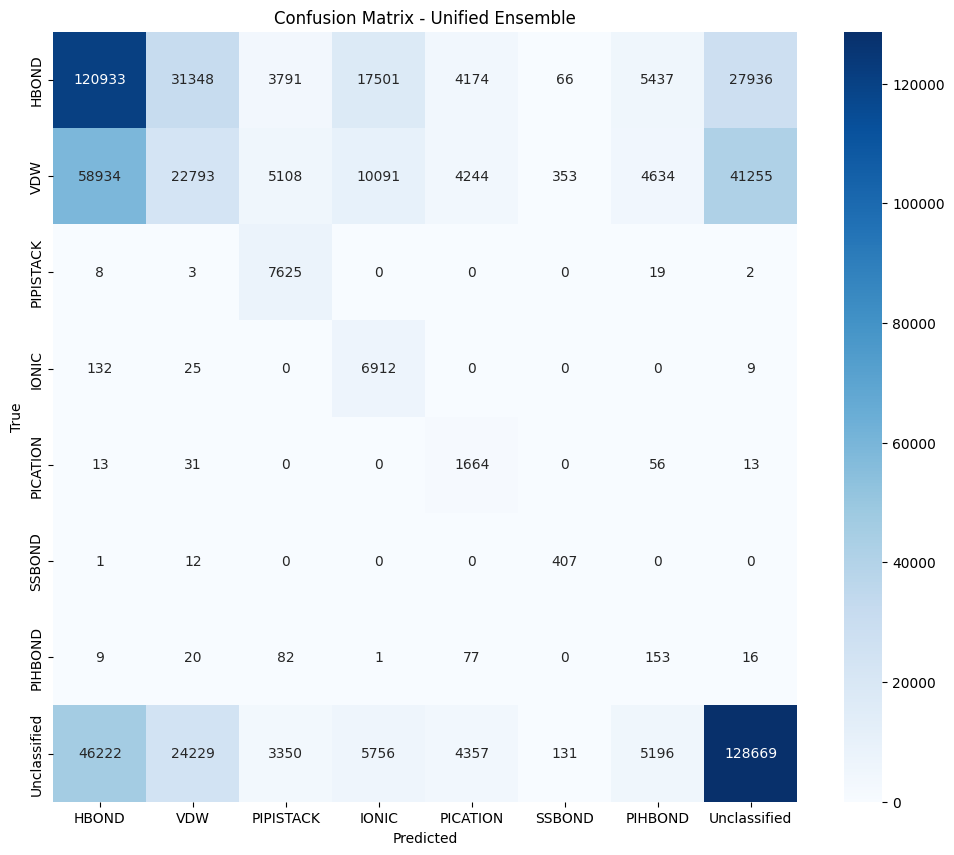

In [ ]:
import xgboost as xgb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    confusion_matrix, roc_auc_score, average_precision_score
)

class UnifiedXGBoostEnsemble:
    """Unified model that combines multiple binary XGBoost models"""

    def __init__(self, models_dir):
        """Load all models from the directory"""
        self.models = []
        self.models_dir = models_dir

        # Load models in order by class number
        for class_num in range(8):  # Assuming 8 classes
            model_path = os.path.join(models_dir, f"xgboost_model_class_{class_num}.json")
            if os.path.exists(model_path):
                model = xgb.Booster()
                model.load_model(model_path)
                self.models.append(model)

        self.n_classes = len(self.models)
        print(f"Successfully loaded {self.n_classes} models from {models_dir}")

    def predict_proba(self, X):
        """Get probability predictions from all models"""
        dtest = xgb.DMatrix(X)
        probas = []

        for model in self.models:
            # Get class probability from each model
            proba = model.predict(dtest)
            probas.append(proba)

        # Stack into a samples x classes matrix
        return np.column_stack(probas)

    def predict(self, X):
        """Make final predictions using max probability"""
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)


def evaluate_unified_ensemble(model, X_test, y_test, class_names=None):
    """
    Evaluate the unified ensemble with comprehensive metrics
    """
    if class_names is None:
        class_names = [f"Class {i}" for i in range(model.n_classes)]

    print("\n===== Evaluating Unified Ensemble (Max Probability) =====\n")

    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    probas = model.predict_proba(X_test)

    # Calculate overall metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'Matthews Correlation Coefficient'
        ],
        'Value': [
            accuracy_score(y_test, y_pred),
            balanced_accuracy_score(y_test, y_pred),
            matthews_corrcoef(y_test, y_pred)
        ]
    }

    # Print overall metrics
    metrics_df = pd.DataFrame(metrics)
    print("Overall Metrics:")
    print(metrics_df.set_index('Metric').round(4))

    # Calculate per-class metrics
    roc_aucs = []
    avg_precisions = []

    print("\nPer-Class Metrics:")
    for i in range(model.n_classes):
        # Binary encoding for this class
        y_true_bin = (y_test == i).astype(int)
        y_score = probas[:, i]

        # ROC AUC
        roc_auc = roc_auc_score(y_true_bin, y_score)
        roc_aucs.append(roc_auc)

        # Average Precision
        avg_prec = average_precision_score(y_true_bin, y_score)
        avg_precisions.append(avg_prec)

        print(f"{class_names[i]}: ROC AUC = {roc_auc:.4f}, Avg Precision = {avg_prec:.4f}")

    print(f"\nMacro-Average ROC AUC: {np.mean(roc_aucs):.4f}")
    print(f"Macro-Average Precision: {np.mean(avg_precisions):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Unified Ensemble')
    plt.show()

    return {
        'accuracy': metrics['Value'][0],
        'balanced_accuracy': metrics['Value'][1],
        'matthews_corr': metrics['Value'][2],
        'roc_auc_per_class': roc_aucs,
        'avg_precision_per_class': avg_precisions,
        'predictions': y_pred,
        'probabilities': probas
    }

# Usage example
models_dir = 'models/bin_models'
class_names = ["HBOND", "VDW", "PIPISTACK", "IONIC", "PICATION", "SSBOND", "PIHBOND", "Unclassified"]

# Create and evaluate the unified model
unified_model = UnifiedXGBoostEnsemble(models_dir)
results = evaluate_unified_ensemble(unified_model, X_test, y_test, class_names)

## Pruning models

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict

def analyze_xgboost_model(model_path):
    """Analyze an XGBoost model JSON file and extract useful information."""
    with open(model_path, 'r') as f:
        model_data = json.load(f)

    # Extract basic model information
    results = {}

    # Model metadata and version
    results['version'] = '.'.join(map(str, model_data.get('learner', {}).get('version', ["unknown"])))

    # Model attributes (parameters)
    attributes = model_data.get('learner', {}).get('attributes', {})
    results['best_iteration'] = int(attributes.get('best_iteration', -1))
    results['best_score'] = float(attributes.get('best_score', -1))

    # Extract hyperparameters
    for key in ['max_depth', 'learning_rate', 'objective', 'eval_metric', 'num_class',
                'scale_pos_weight', 'seed', 'num_parallel_tree', 'subsample', 'colsample_bytree']:
        if key in attributes:
            try:
                value = attributes[key]
                # Convert numeric strings to proper types
                if isinstance(value, str) and value.replace('.', '', 1).isdigit():
                    if '.' in value:
                        results[key] = float(value)
                    else:
                        results[key] = int(value)
                else:
                    results[key] = value
            except:
                results[key] = attributes[key]

    # Extract tree information
    tree_model = model_data.get('learner', {}).get('gradient_booster', {}).get('model', {})

    # Tree model parameters
    gbtree_params = tree_model.get('gbtree_model_param', {})
    results['num_trees'] = int(gbtree_params.get('num_trees', 0))

    # Trees analysis
    trees = tree_model.get('trees', [])

    # Tree statistics
    tree_stats = []
    total_nodes = 0
    total_leaves = 0
    used_features = set()
    feature_importance = defaultdict(int)

    for i, tree in enumerate(trees):
        tree_param = tree.get('tree_param', {})
        num_nodes = int(tree_param.get('num_nodes', 0))
        split_indices = tree.get('split_indices', [])

        # Calculate leaves (nodes that are not internal nodes)
        internal_nodes = set()
        for j in range(len(tree.get('left_children', []))):
            if tree['left_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)
            if tree['right_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)

        num_leaves = num_nodes - len(internal_nodes)

        # Track feature usage as a simple feature importance
        for feature_idx in split_indices:
            used_features.add(feature_idx)
            feature_importance[feature_idx] += 1

        # Store tree statistics
        tree_stats.append({
            'tree_index': i,
            'num_nodes': num_nodes,
            'num_leaves': num_leaves,
            'max_depth': max_tree_depth(tree),
            'num_features_used': len(set(split_indices))
        })

        total_nodes += num_nodes
        total_leaves += num_leaves

    results['total_nodes'] = total_nodes
    results['total_leaves'] = total_leaves
    results['avg_nodes_per_tree'] = total_nodes / results['num_trees'] if results['num_trees'] > 0 else 0
    results['avg_leaves_per_tree'] = total_leaves / results['num_trees'] if results['num_trees'] > 0 else 0
    results['num_features_used'] = len(used_features)

    # Sort feature importance
    results['top_features'] = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]

    # Compute tree depth statistics
    depths = [stat['max_depth'] for stat in tree_stats]
    results['min_tree_depth'] = min(depths) if depths else 0
    results['max_tree_depth'] = max(depths) if depths else 0
    results['avg_tree_depth'] = sum(depths) / len(depths) if depths else 0

    # File metrics
    results['file_size_kb'] = os.path.getsize(model_path) / 1024

    return results, tree_stats

def max_tree_depth(tree):
    """Calculate the maximum depth of a tree by following child nodes."""
    left = tree.get('left_children', [])
    right = tree.get('right_children', [])

    if not left or not right:
        return 0

    # Use BFS to find the maximum depth
    depths = {0: 0}  # node_id: depth
    max_depth = 0

    for node_id in range(len(left)):
        node_depth = depths.get(node_id, 0)

        # Process left child
        if left[node_id] >= 0:  # Valid node
            depths[left[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)

        # Process right child
        if right[node_id] >= 0:  # Valid node
            depths[right[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)

    return max_depth

# Usage example
models_dir = '/Users/sebastianosanson/Development/Contacts-Classification/models'
all_model_results = []
all_tree_stats = []

# Process all model files
for filename in sorted(os.listdir(models_dir)):
    if filename.endswith('.json'):
        model_path = os.path.join(models_dir, filename)
        class_num = int(filename.split('_')[-1].split('.')[0])

        # Extract model information
        model_info, tree_stats = analyze_xgboost_model(model_path)
        model_info['class'] = class_num

        # Add model information to results
        all_model_results.append(model_info)

        # Add tree statistics with model identifier
        for stat in tree_stats:
            stat['class'] = class_num
            all_tree_stats.append(stat)

# Create DataFrame for easy analysis
models_df = pd.DataFrame(all_model_results)
trees_df = pd.DataFrame(all_tree_stats)

# Print the high-level model information
print("\n===== MODEL INFORMATION =====")
print(models_df[['class', 'num_trees', 'best_iteration', 'best_score',
                 'total_nodes', 'avg_nodes_per_tree', 'avg_tree_depth',
                 'file_size_kb']].sort_values('class'))

# Print tree depth statistics
print("\n===== TREE DEPTH STATISTICS =====")
tree_depth_stats = trees_df.groupby('class').agg({
    'max_depth': ['min', 'max', 'mean']
}).reset_index()
print(tree_depth_stats)

# Feature importance across models
print("\n===== TOP FEATURES BY CLASS =====")
for i, model in enumerate(all_model_results):
    print(f"\nClass {model['class']} top features:")
    for feature_idx, count in model['top_features'][:]:
        print(f"  Feature {feature_names[feature_idx]}: used {count} times")

## Features selection

Selected features: ['s_rsa', 's_phi', 't_ss8', 't_rsa', 's_ss8', 'phi_abs_diff', 'psi_abs_diff', 's_3di_state', 'rsa_abs_diff', 'psi_sum', 'phi_sum', 'rsa_sum', 't_a4', 's_a5', 'rsa_prod', 'psi_prod', '3di_state_abs_diff', 'phi_prod', '3di_state_sum']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:16:33] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-auc:0.61997
[100]	eval-auc:0.67025
[200]	eval-auc:0.67124
[300]	eval-auc:0.66942
[344]	eval-auc:0.66852

===== Performance Metrics for Class 0 =====
                          Value
Metric                         
Accuracy                 0.6139
Balanced Accuracy        0.6197
AUC-ROC                  0.6685
Matthews Correlation     0.2293
Average Precision        0.5117
Inference Time (ms)   1453.0401


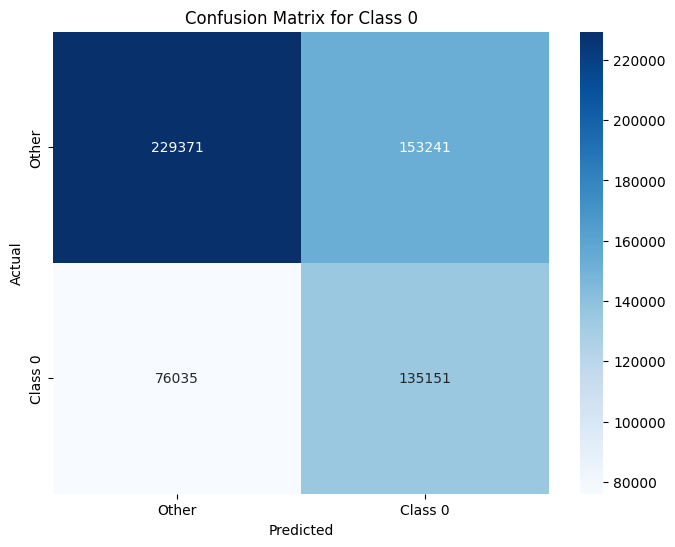


===== Feature Importance for Class 0 =====


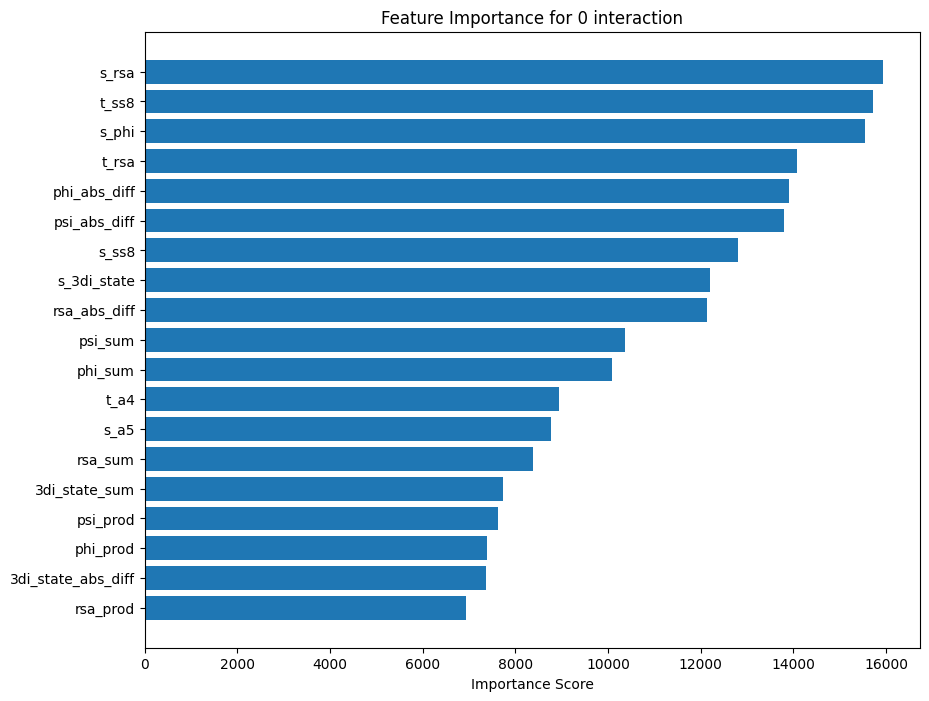

Selected features: ['s_phi', 's_rsa', 't_ss8', 'psi_abs_diff', 't_rsa', 'phi_abs_diff', 's_ss8', 'rsa_abs_diff', 's_3di_state', 'psi_sum', 'phi_sum', 's_a5', 'rsa_sum', 't_a4', 'rsa_prod', 'psi_prod', 'phi_prod', '3di_state_abs_diff', '3di_state_sum']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:17:15] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-auc:0.53178
[53]	eval-auc:0.53958

===== Performance Metrics for Class 1 =====
                         Value
Metric                        
Accuracy                0.5015
Balanced Accuracy       0.5279
AUC-ROC                 0.5396
Matthews Correlation    0.0483
Average Precision       0.2713
Inference Time (ms)   243.0470


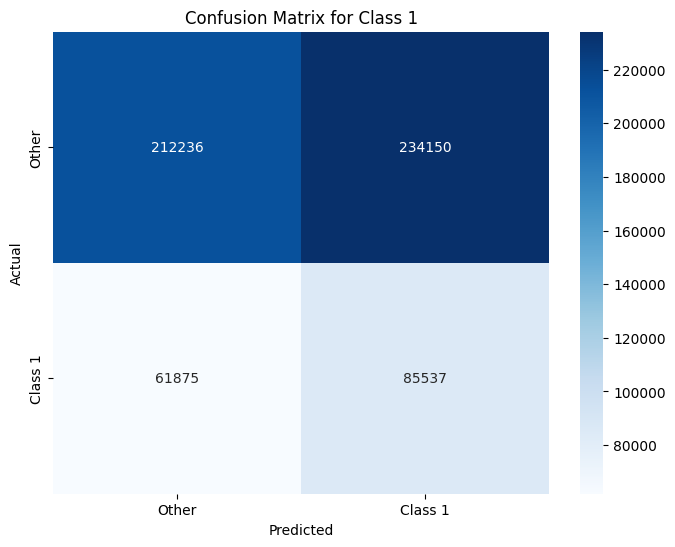


===== Feature Importance for Class 1 =====


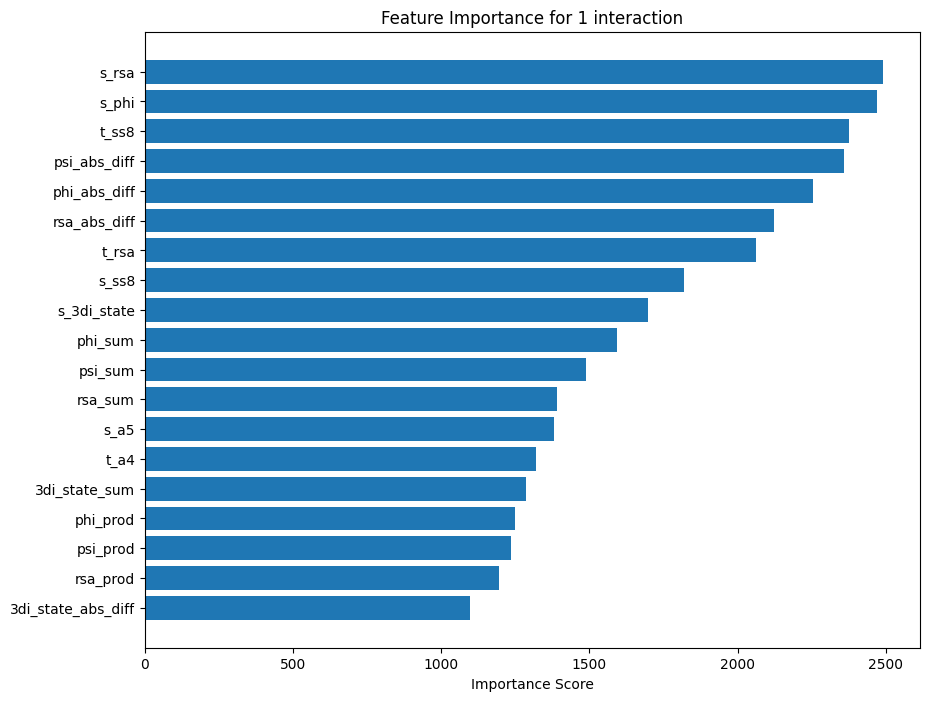

Selected features: ['psi_abs_diff', 'psi_prod', 's_ss8', 'rsa_abs_diff', 'rsa_prod', 's_3di_state', 't_rsa', '3di_state_sum', 's_phi', 'phi_abs_diff', '3di_state_abs_diff', 's_a5', 's_rsa', 't_ss8', 'psi_sum', 'ss8_encoded_sum', 'a4_sum', 'ss8_encoded_abs_diff', 'a1_sum', 't_a4', 'phi_prod', 't_a2', 'a1_prod', 'phi_sum']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:17:24] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-auc:0.98945
[76]	eval-auc:0.99093

===== Performance Metrics for Class 2 =====
                         Value
Metric                        
Accuracy                0.9789
Balanced Accuracy       0.9886
AUC-ROC                 0.9909
Matthews Correlation    0.6090
Average Precision       0.4458
Inference Time (ms)   101.2690


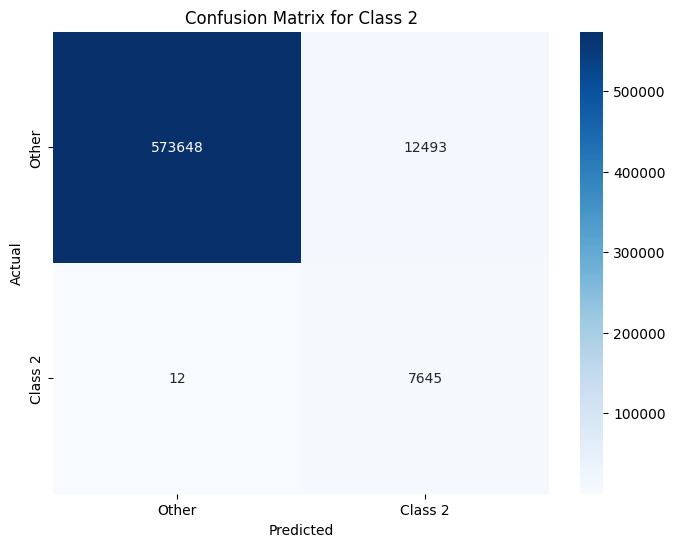


===== Feature Importance for Class 2 =====


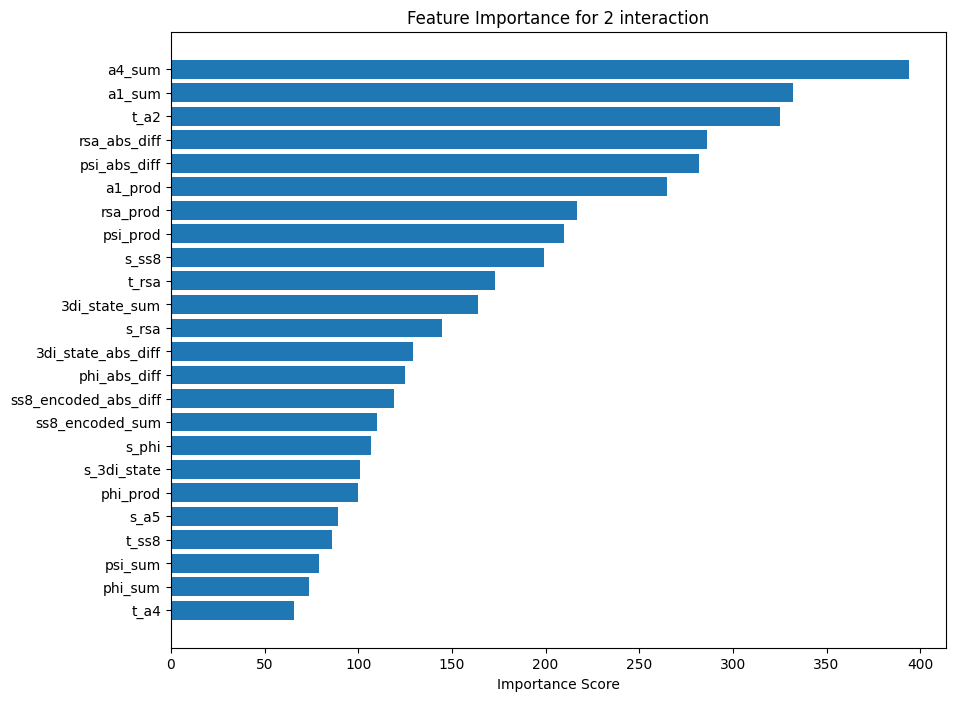

Selected features: ['rsa_abs_diff', 's_ss8', 'rsa_sum', 's_phi', 's_3di_state', 't_rsa', 'psi_abs_diff', 't_ss8', 'psi_sum', 'phi_abs_diff', 's_rsa', 'rsa_prod', 'psi_prod', 't_a4', 'a1_sum', '3di_state_sum', 'phi_sum', '3di_state_abs_diff', 'phi_prod', 's_a5']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:17:30] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-auc:0.97649
[61]	eval-auc:0.97667

===== Performance Metrics for Class 3 =====
                         Value
Metric                        
Accuracy                0.9428
Balanced Accuracy       0.9600
AUC-ROC                 0.9767
Matthews Correlation    0.3950
Average Precision       0.2278
Inference Time (ms)   105.7689


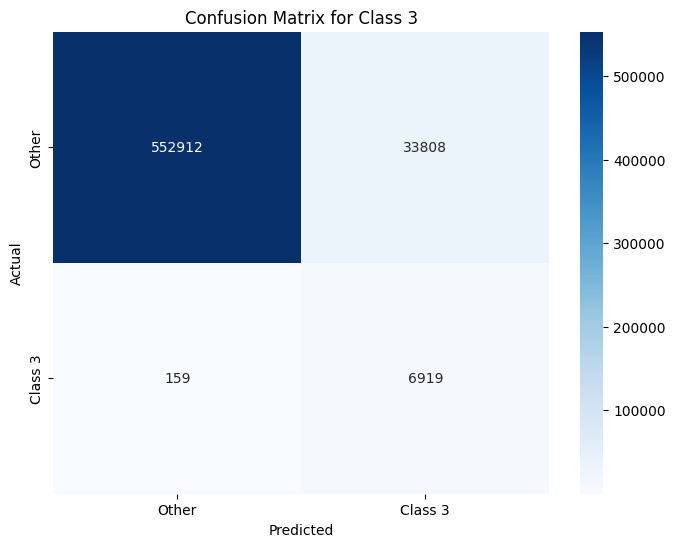


===== Feature Importance for Class 3 =====


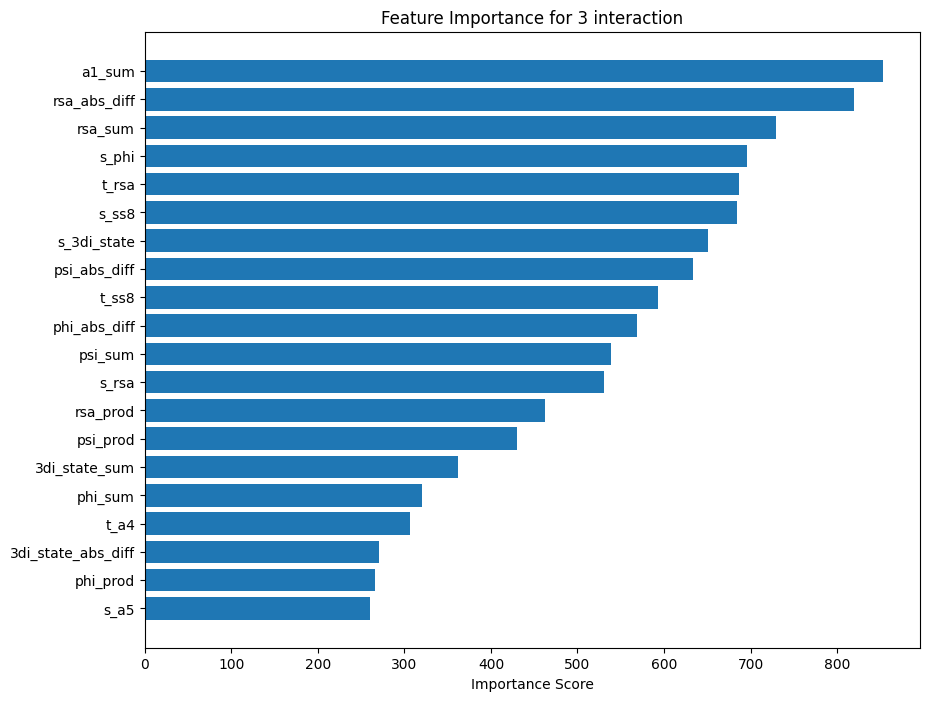

Selected features: ['rsa_abs_diff', 'rsa_prod', 's_rsa', 's_3di_state', 'rsa_sum', 't_a4', 's_phi', 't_rsa', 't_ss8', 'phi_abs_diff', 's_ss8', 'psi_abs_diff', 'psi_sum', 's_a5', 'ss8_encoded_abs_diff', 'a1_abs_diff', 'psi_prod', 'phi_sum', '3di_state_abs_diff', 'a1_sum', '3di_state_sum']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:17:35] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-auc:0.98897
[46]	eval-auc:0.99109

===== Performance Metrics for Class 4 =====
                        Value
Metric                       
Accuracy               0.9753
Balanced Accuracy      0.9710
AUC-ROC                0.9911
Matthews Correlation   0.3145
Average Precision      0.1793
Inference Time (ms)   87.4190


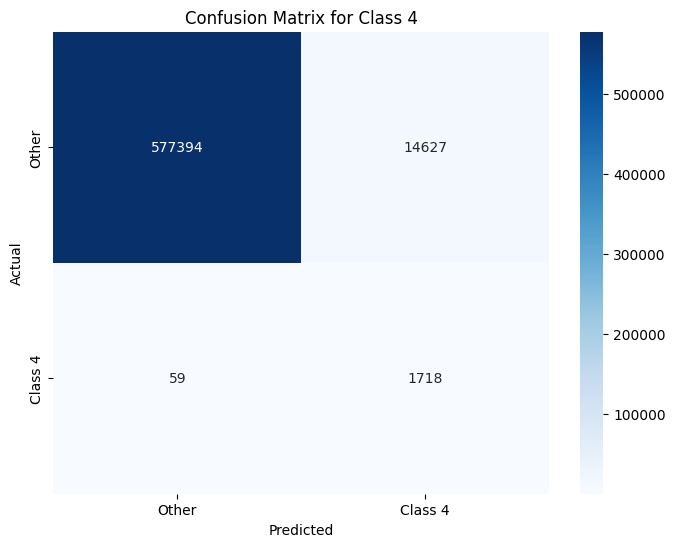


===== Feature Importance for Class 4 =====


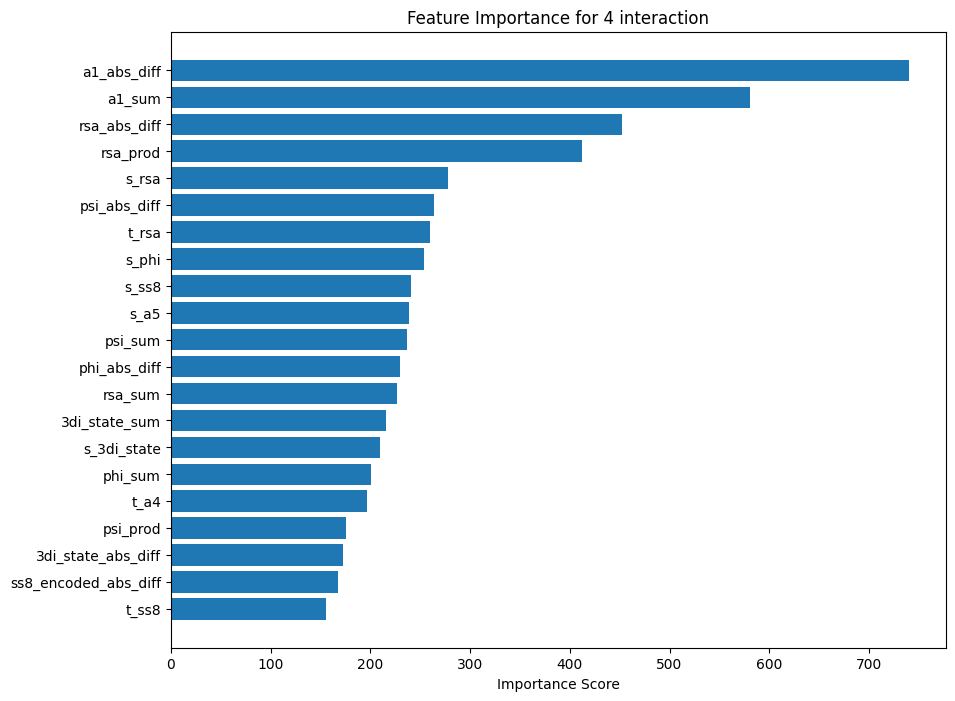

Selected features: ['s_ss8', 's_rsa', 't_rsa', 't_ss8', 'psi_abs_diff', 's_phi', 'phi_abs_diff', 't_a4', 's_3di_state']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:17:39] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-auc:0.76138
[32]	eval-auc:0.81648

===== Performance Metrics for Class 5 =====
                         Value
Metric                        
Accuracy                0.8413
Balanced Accuracy       0.7124
AUC-ROC                 0.8165
Matthews Correlation    0.0309
Average Precision       0.0141
Inference Time (ms)   177.7818


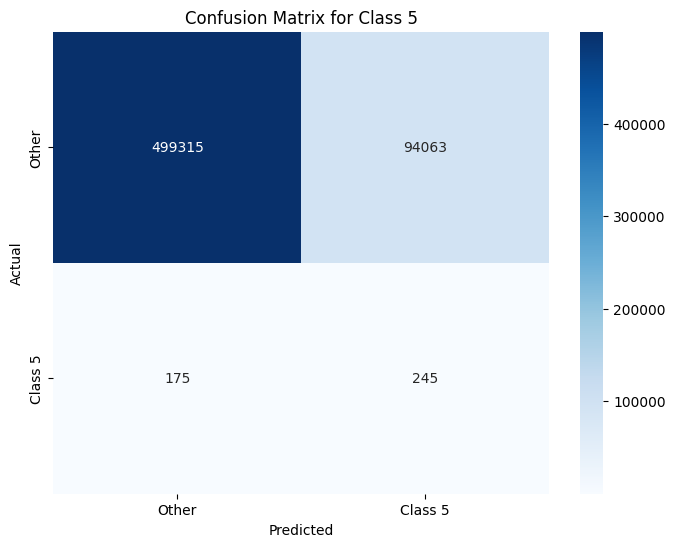


===== Feature Importance for Class 5 =====


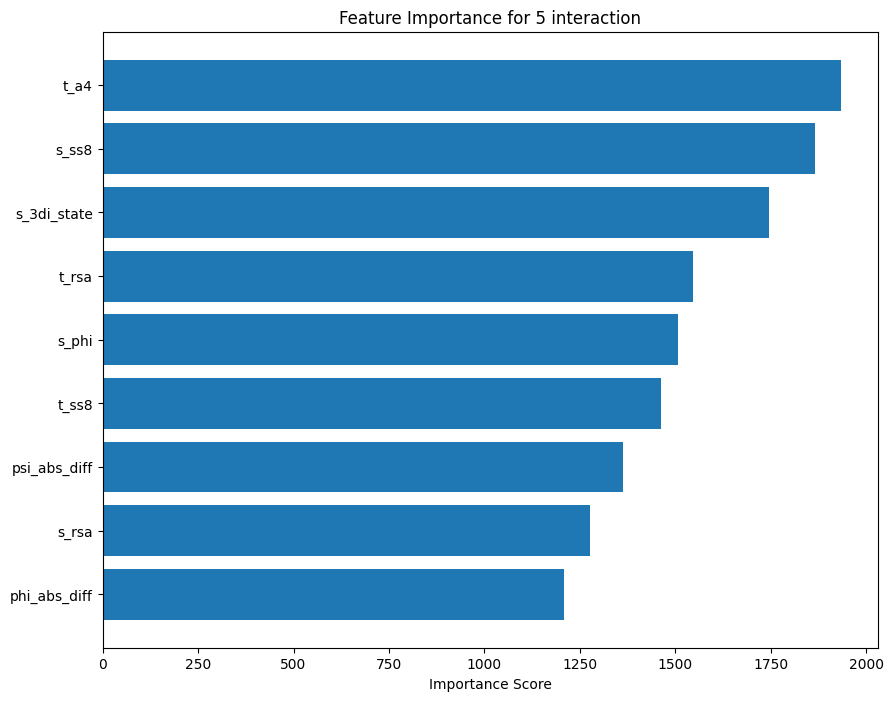

Selected features: ['ss8_encoded_abs_diff', 'phi_abs_diff', 's_rsa', 's_phi', 'a1_sum', 't_ss8', 's_3di_state', 's_ss8', 'rsa_abs_diff', 't_rsa', 'psi_sum', 'psi_abs_diff', 'a4_sum', 's_psi', '3di_state_abs_diff', 'rsa_prod', 'a3_sum', 't_a4', '3di_state_sum', 'phi_sum', 'ss8_encoded_sum', 'psi_prod', 's_a5', 'a2_abs_diff', 'a5_sum', 't_a5']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:17:44] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-auc:0.93608
[1]	eval-auc:0.93511

===== Performance Metrics for Class 6 =====
                        Value
Metric                       
Accuracy               0.9044
Balanced Accuracy      0.8768
AUC-ROC                0.9351
Matthews Correlation   0.0628
Average Precision      0.0086
Inference Time (ms)   15.3639


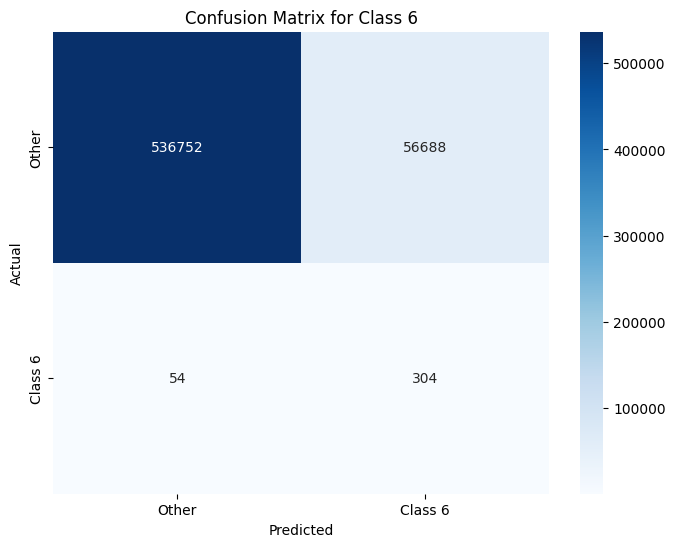


===== Feature Importance for Class 6 =====


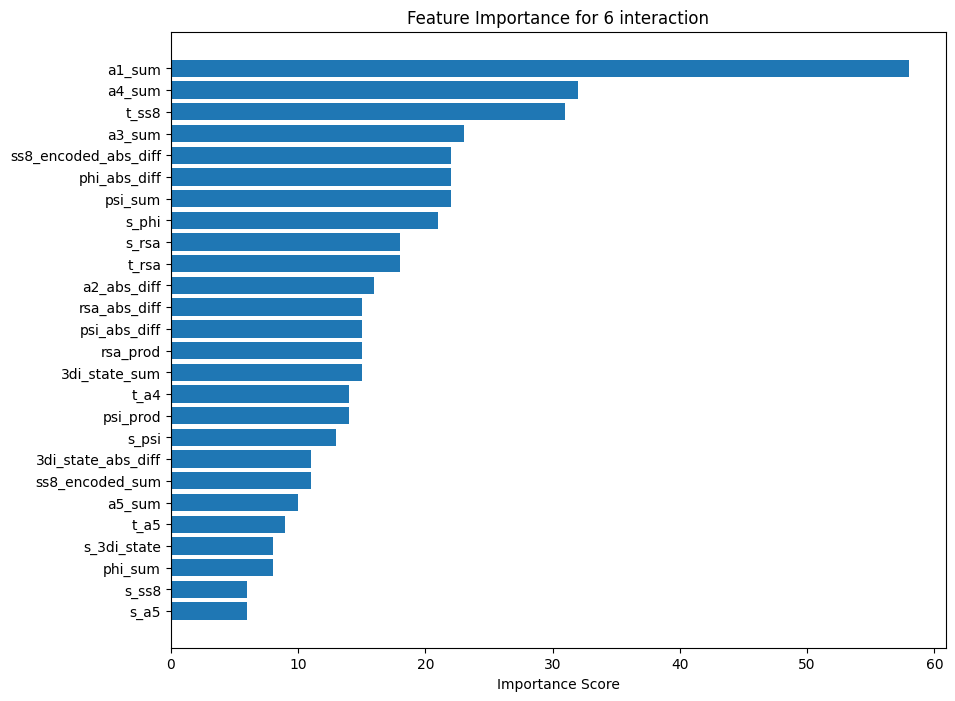

Selected features: ['phi_abs_diff', 's_rsa', 's_phi', 'psi_abs_diff', 't_ss8', 't_rsa', 'rsa_abs_diff', 's_ss8', 's_3di_state', 'rsa_sum', 'psi_sum', 'phi_sum', 'psi_prod', 'rsa_prod', '3di_state_abs_diff', 'phi_prod', 't_a4', '3di_state_sum']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:17:51] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-auc:0.61299
[100]	eval-auc:0.67418
[200]	eval-auc:0.68384
[300]	eval-auc:0.68982
[400]	eval-auc:0.69384
[500]	eval-auc:0.69698
[600]	eval-auc:0.69957
[700]	eval-auc:0.70174
[800]	eval-auc:0.70391
[900]	eval-auc:0.70588
[1000]	eval-auc:0.70769
[1100]	eval-auc:0.70924
[1200]	eval-auc:0.71083
[1300]	eval-auc:0.71242
[1400]	eval-auc:0.71361
[1500]	eval-auc:0.71462
[1600]	eval-auc:0.71568
[1700]	eval-auc:0.71669
[1800]	eval-auc:0.71782
[1900]	eval-auc:0.71883
[2000]	eval-auc:0.71978
[2100]	eval-auc:0.72081
[2200]	eval-auc:0.72163
[2300]	eval-auc:0.72230
[2400]	eval-auc:0.72305
[2499]	eval-auc:0.72388

===== Performance Metrics for Class 7 =====
                           Value
Metric                          
Accuracy                  0.6788
Balanced Accuracy         0.6595
AUC-ROC                   0.7239
Matthews Correlation      0.3160
Average Precision         0.5917
Inference Time (ms)   15361.5448


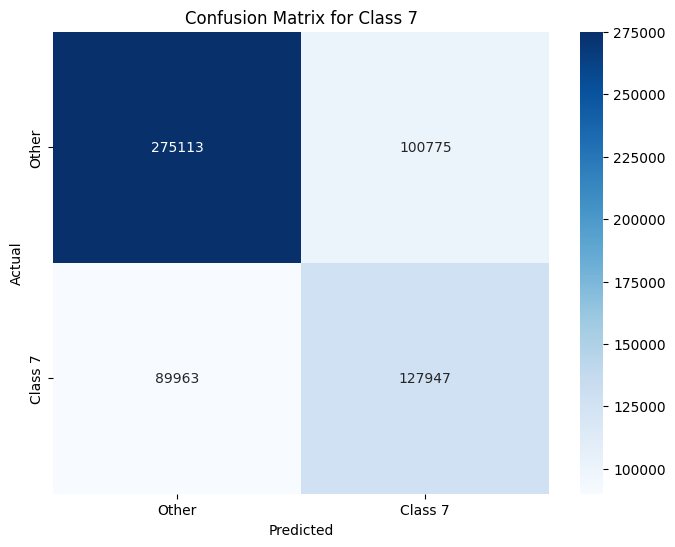


===== Feature Importance for Class 7 =====


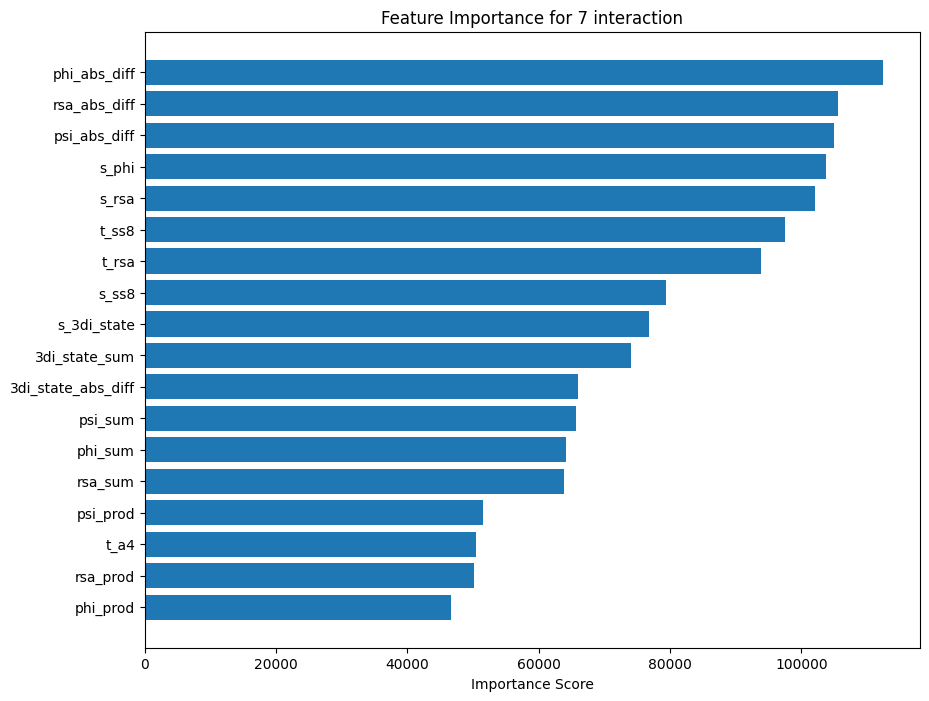

In [23]:
models_dir = 'models/bin_models'
model_files = [f for f in os.listdir(models_dir) if f.startswith('xgboost_model_class_') and f.endswith('.json')]
model_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

for filename in model_files:
    model_path = os.path.join(models_dir, filename)
    model = xgb.Booster()
    model.load_model(model_path)

    # Get feature importances as a dictionary
    importance = model.get_score(importance_type='weight')

    # Extract the importance values and calculate their mean using numpy
    # Handle case where importance dictionary might be empty
    if importance:
        importance_values = np.array(list(importance.values()))
        threshold = np.mean(importance_values)
    else:
        print(f"Warning: No feature importance scores found for model {filename}. Skipping feature selection.")
        continue # Skip feature selection and training for this model

    # Create a dictionary mapping original feature indices to importance scores
    # XGBoost's get_score returns f0, f1, f2... if no feature_names are provided
    # Need to handle the case where feature_names might not have been passed to DMatrix
    # Assuming importance keys are 'f0', 'f1', ... corresponding to column indices 0, 1, ...
    # We will create a dummy feature importance structure that SelectFromModel can use
    # SelectFromModel requires a model with a `feature_importances_` or `coef_` attribute
    # We can create a dummy model-like object or use SelectFromModel directly with the scores

    # A better approach for SelectFromModel with xgb.Booster is to manually apply the threshold

    # Get features sorted by importance
    sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

    # Select features based on the threshold
    selected_feature_indices = [int(key[1:]) for key, score in sorted_importance if score > threshold]

    if not selected_feature_indices:
        print(f"Warning: No features selected for model {filename} with threshold {threshold}. Skipping training for this model.")
        continue # Skip training if no features are selected

    # Ensure selected_feature_indices are within the bounds of X_train columns
    max_feature_index = X_train.shape[1] - 1
    selected_feature_indices = [idx for idx in selected_feature_indices if idx <= max_feature_index]

    if not selected_feature_indices:
        print(f"Warning: Selected feature indices out of bounds for model {filename}. Skipping training.")
        continue

    # Filter training/test data using selected indices
    # Ensure X_train and X_test are numpy arrays for integer indexing
    X_train_selected = X_train[:, selected_feature_indices]
    X_test_selected = X_test[:, selected_feature_indices]

    # Get the original feature names if available (assuming 'feature_names' is accessible from previous cells)
    # This part might need adjustment based on how 'feature_names' was defined and used
    try:
        selected_features_names = [feature_names[idx] for idx in selected_feature_indices]
        print(f"Selected features: {selected_features_names}")
    except NameError:
         print(f"Selected feature indices: {selected_feature_indices}")
         print("Cannot retrieve feature names: 'feature_names' variable not found.")


    # Train a new model with selected features
    # We need to train a new XGBoost model (XGBClassifier or xgb.train)
    # The original code used xgb.train, let's stick to that for consistency with DMatrix

    # Assuming y_train and y_test are still the original multi-class labels
    # For the SelectFromModel approach as originally intended, you might need to train a
    # multi-class XGBClassifier or handle binary classification within this loop

    # Let's assume the goal is still binary classification per class for pruning
    # Need the corresponding binary labels for training and testing

    # Get the class number from the filename
    class_num = int(filename.split('_')[-1].split('.')[0])
    y_train_binary = (y_train == class_num).astype(int)
    y_test_binary = (y_test == class_num).astype(int)

    dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train_binary)
    dtest_selected = xgb.DMatrix(X_test_selected, label=y_test_binary)

    # Recalculate scale_pos_weight for the potentially reduced dataset (though SMOTE makes it balanced)
    pos_class_selected = np.sum(y_train_binary == 1)
    neg_class_selected = np.sum(y_train_binary == 0)
    scale_pos_weight_selected = neg_class_selected / pos_class_selected if pos_class_selected > 0 else 1.0

    # Train the pruned model
    pruned_model = xgb.train(
        params={
            'device': 'cuda',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 10, # Keep hyperparameters consistent or tune again
            'learning_rate': 0.1, # Use the original learning rate or tune
            'scale_pos_weight': scale_pos_weight_selected,
            'seed': 42
        },
        dtrain=dtrain_selected,
        num_boost_round=model.best_iteration + 1 if hasattr(model, 'best_iteration') else 100, # Use best_iteration from original model or a fixed number
        evals=[(dtest_selected, 'eval')], # Evaluate on test set for comparison, could use a separate validation set
        verbose_eval=100
    )

    evaluate_model(pruned_model, X_test_selected, y_test, class_num, selected_features_names, selected_feature_indices=selected_feature_indices)

    # # Evaluate the new model
    # y_pred_selected_prob = pruned_model.predict(dtest_selected)
    # y_pred_selected_binary = (y_pred_selected_prob > 0.5).astype(int)

    # selected_accuracy = accuracy_score(y_test_binary, y_pred_selected_binary)
    # selected_bal_accuracy = balanced_accuracy_score(y_test_binary, y_pred_selected_binary)
    # selected_auc = roc_auc_score(y_test_binary, y_pred_selected_prob)
    # selected_ap = average_precision_score(y_test_binary, y_pred_selected_prob)
    # selected_mcc = matthews_corrcoef(y_test_binary, y_pred_selected_binary)


    # print(f"Class {class_num} - Accuracy with selected features: {selected_accuracy:.4f}")
    # print(f"Class {class_num} - Balanced Accuracy with selected features: {selected_bal_accuracy:.4f}")
    # print(f"Class {class_num} - AUC with selected features: {selected_auc:.4f}")
    # print(f"Class {class_num} - AP with selected features: {selected_ap:.4f}")
    # print(f"Class {class_num} - MCC with selected features: {selected_mcc:.4f}")

    # Optionally, save the pruned model
    os.makedirs(os.path.join(path, 'models/bin_models_pruned_mean_threshold'), exist_ok=True)
    pruned_model.save_model(os.path.join(path, f'xgboost_model_class_{class_num}.json'))

In [ ]:
# import xgboost as xgb
# import numpy as np
# import pandas as pd
# from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
# from sklearn.metrics import matthews_corrcoef, average_precision_score
# import matplotlib.pyplot as plt
# import time

# def evaluate_model_comparison(original_model_path, pruned_model_path, X_test, y_test, class_num):
#     """
#     Compare performance between original and pruned XGBoost models.

#     Parameters:
#     -----------
#     original_model_path: str
#         Path to the original model file
#     pruned_model_path: str
#         Path to the pruned model file
#     X_test: numpy array
#         Test features
#     y_test: numpy array
#         Test labels
#     class_num: int
#         Class number for binary evaluation
#     """
#     # 1. Load both models
#     original_model = xgb.Booster()
#     original_model.load_model(original_model_path)

#     pruned_model = xgb.Booster()
#     pruned_model.load_model(pruned_model_path)

#     # 2. Convert test data to DMatrix
#     dtest = xgb.DMatrix(X_test)

#     # 3. Make predictions
#     # Convert to binary task (1 for current class, 0 for other classes)
#     y_test_binary = (y_test == class_num).astype(int)

#     # Get predictions from both models
#     start_time = time.time()
#     y_pred_orig = original_model.predict(dtest)
#     orig_time = time.time() - start_time

#     start_time = time.time()
#     y_pred_pruned = pruned_model.predict(dtest)
#     pruned_time = time.time() - start_time

#     # 4. Convert probabilities to binary predictions
#     y_pred_orig_binary = (y_pred_orig > 0.5).astype(int)
#     y_pred_pruned_binary = (y_pred_pruned > 0.5).astype(int)

#     # 5. Calculate metrics
#     metrics = {
#         'Model': ['Original', 'Pruned'],
#         'Accuracy': [
#             accuracy_score(y_test_binary, y_pred_orig_binary),
#             accuracy_score(y_test_binary, y_pred_pruned_binary)
#         ],
#         'Balanced Accuracy': [
#             balanced_accuracy_score(y_test_binary, y_pred_orig_binary),
#             balanced_accuracy_score(y_test_binary, y_pred_pruned_binary)
#         ],
#         'AUC-ROC': [
#             roc_auc_score(y_test_binary, y_pred_orig),
#             roc_auc_score(y_test_binary, y_pred_pruned)
#         ],
#         'Matthews Correlation': [
#             matthews_corrcoef(y_test_binary, y_pred_orig_binary),
#             matthews_corrcoef(y_test_binary, y_pred_pruned_binary)
#         ],
#         'Average Precision': [
#             average_precision_score(y_test_binary, y_pred_orig),
#             average_precision_score(y_test_binary, y_pred_pruned)
#         ],
#         'Inference Time (ms)': [
#             orig_time * 1000,
#             pruned_time * 1000
#         ]
#     }

#     # Calculate file size
#     import os
#     metrics['Model Size (KB)'] = [
#         os.path.getsize(original_model_path) / 1024,
#         os.path.getsize(pruned_model_path) / 1024
#     ]

#     # 6. Create a DataFrame for metrics
#     metrics_df = pd.DataFrame(metrics)

#     # 7. Calculate performance difference
#     diff_row = {
#         'Model': 'Difference (%)',
#         'Accuracy': (metrics['Accuracy'][1] - metrics['Accuracy'][0]) / metrics['Accuracy'][0] * 100,
#         'Balanced Accuracy': (metrics['Balanced Accuracy'][1] - metrics['Balanced Accuracy'][0]) / metrics['Balanced Accuracy'][0] * 100,
#         'AUC-ROC': (metrics['AUC-ROC'][1] - metrics['AUC-ROC'][0]) / metrics['AUC-ROC'][0] * 100,
#         'Matthews Correlation': (metrics['Matthews Correlation'][1] - metrics['Matthews Correlation'][0]) / max(0.0001, metrics['Matthews Correlation'][0]) * 100,
#         'Average Precision': (metrics['Average Precision'][1] - metrics['Average Precision'][0]) / metrics['Average Precision'][0] * 100,
#         'Inference Time (ms)': (metrics['Inference Time (ms)'][1] - metrics['Inference Time (ms)'][0]) / metrics['Inference Time (ms)'][0] * 100,
#         'Model Size (KB)': (metrics['Model Size (KB)'][1] - metrics['Model Size (KB)'][0]) / metrics['Model Size (KB)'][0] * 100
#     }
#     metrics_df = pd.concat([metrics_df, pd.DataFrame([diff_row])], ignore_index=True)

#     print(f"\n===== Performance Comparison for Class {class_num} =====")
#     print(metrics_df.round(4))

#     # 8. Plot prediction correlation
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_pred_orig, y_pred_pruned, alpha=0.3)
#     plt.plot([0, 1], [0, 1], 'r--')
#     plt.xlabel('Original Model Predictions')
#     plt.ylabel('Pruned Model Predictions')
#     plt.title(f'Prediction Correlation for Class {class_num}')
#     plt.grid(True, alpha=0.3)
#     correlation = np.corrcoef(y_pred_orig, y_pred_pruned)[0, 1]
#     plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes)
#     plt.show()

#     return metrics_df

# # Example usage
# # class_num = 0  # For HBOND class
# # original_path = '/Users/sebastianosanson/Development/Contacts-Classification/models/xgboost_model_class_0.json'
# # pruned_path = '/Users/sebastianosanson/Development/Contacts-Classification/models/xgboost_model_class_0_pruned.json'
# # results = evaluate_model_comparison(original_path, pruned_path, X_test, y_test, class_num)